# Домашнее задание "Варианционные автоэнкодеры"

**Автор**: Ермекова Асель

В этом домашнем задании вам предстоит реализовать VAE для датасета картинок MNIST.

Вы научитесь обучать вариационный автоэнкодер (VAE) генерировать новые изображения с нуля. А также сможете управлять генерацией, указывая желаемый класс объекта, и оценивать качество результата с помощью метрики FID.

Это домашнее задание состоит из двух частей:

* **I часть.** Реализовать безусловную генерацию картинок при помощи VAE тренированную на датасете MNIST и оценить качество по метрике FID.
* **II часть.** Реализовать условную генерацию по классу и оценить качество по метрике FID.



     

Установите библиотеку для подсчета FID:

In [ ]:
!pip install pytorch-fid

## **I часть. Unconditional VAE (6 баллов)**

### Библиотеки

In [ ]:
# TODO
# Импортните любые необходимые вам библиотеки
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import random
import copy

### Датасет.

**Задание**: Скачайте датасет MNIST и подготовьте train dataloader.

In [ ]:
# --- Подготовка данных ---
batch_size = 512 # TODO
transform = transforms.Compose([
    transforms.ToTensor(), # [0.0, 1.0] float
    transforms.Lambda(lambda x: (x > 0.5).float()) # Binarize
]) # TODO

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)# TODO

train_loader =  DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True
) # TODO

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.90MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 122kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.94MB/s]


In [ ]:
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)# TODO

**Задание**: Для FID сохраните 10k реальных изображений из MNIST test части в папку

In [ ]:
# TODO: Для FID сохраните 10k реальных изображений из MNIST test части в папку
os.makedirs('mnist_vae_real', exist_ok=True)

for i in range(len(test_dataset)):
    img, _ = test_dataset[i]
    save_image(img, f'mnist_vae_real/real_{i:05d}.png')

**Задание**: Визуализируйте 5 рандомных сэмплов из тренировочных данных и 5 сэмплов из тестовых данных

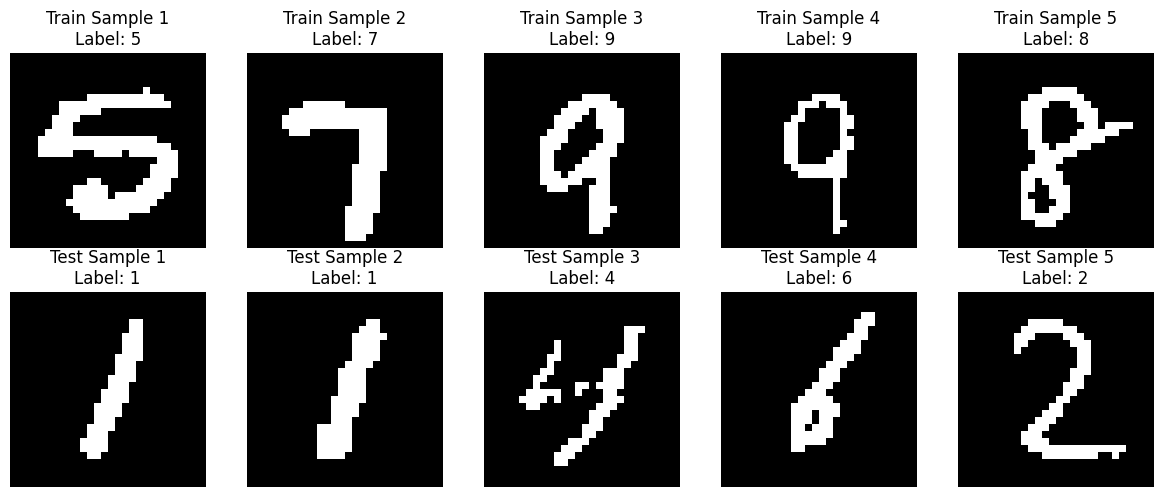

In [ ]:
# TODO

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
    id = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[id]
    axes[0, i].imshow(img[0], cmap='gray')
    axes[0, i].set_title(f'Train Sample {i+1}\nLabel: {label}')
    axes[0, i].axis('off')

for i in range(5):
    id = random.randint(0, len(test_dataset) - 1)
    img, label = test_dataset[id]
    axes[1, i].imshow(img[0], cmap='gray')
    axes[1, i].set_title(f'Test Sample {i+1}\nLabel: {label}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Модель

**Задание**: Реализуйте VAE архитектуру

In [ ]:
# TODO: Реализуйте VAE (безусловный)
class VAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=32, hidden_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Encoder: изображение -> mu, logvar
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 32, kernel_size=4, stride=2, padding=1),  # понизим размерность с 28x28 до 14х14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # понизим размерность до 7х7
            nn.ReLU(),
            nn.Flatten(), # вытягиваем в одномерный вектор, общее кол-во элементов 64*7*7=3136
            nn.Linear(3136, hidden_dim), # делаем вектор с 128 координатам
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )

        # Decoder: z -> изображение
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3136),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)), # делаем 4D-тензор
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # повышаем размерность изображения до 14х14
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_dim, kernel_size=4, stride=2, padding=1), # повышаем размерность изображения до 28х28
            nn.Sigmoid() # ф-я активации
        )

    def encode(self, x):
        # TODO
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # TODO
        # z = mu + sigma * eps, eps ~ N(0, I)
        std = torch.exp(0.5 * logvar) # σ = exp(0.5 * log(σ²))
        eps = torch.randn_like(std) # ε ~ N(0, 1)
        return mu + eps * std # z = μ + σ ⊙ ε

    def decode(self, z):
        # TODO
        return self.decoder(z)

    def forward(self, x):
        # TODO
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        p_recon = self.decode(z)
        return p_recon, mu, logvar, z

### Loss

**Задание**: Напишите VAE Loss

In [ ]:
# TODO: Реализуйте функцию потерь VAE
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss: BCE (since output is sigmoid)
    # TODO
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence: D_KL(q(z|x) || p(z))
    # TODO
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

### Тренировка

**Задание**: Обучите модель на датасете MNIST.

In [ ]:
latent_dim = 32  # MNIST VAEs often use 20–64
hidden_dim = 128
epochs = 30 # TODO
lr = 1e-3
img_size = 28
channels = 1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# TODO: Обучите модель
model = VAE(input_dim=channels, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Обучение...
def train_vae(model, train_loader, epochs=1000):
    train_losses = []
    recon_losses = []
    kl_losses = []
    best_model_state = None
    best_loss = 1e38

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0
        num_batches = 0

        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()

            p_recon, mu, logvar, z = model(x)
            loss, recon_loss, kl_loss = vae_loss(p_recon, x, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            num_batches += 1

        avg_loss = total_loss / len(train_loader.dataset)
        avg_recon = total_recon / len(train_loader.dataset)
        avg_kl = total_kl / len(train_loader.dataset)

        train_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)

        if epoch % 5 == 0:
            print(f'Epoch {epoch:2d}: Loss = {avg_loss:.4f}, '
                  f'Recon = {avg_recon:.4f}, KL = {avg_kl:.4f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = copy.deepcopy(model.state_dict())

    print(f'\nЛучший Loss: {best_loss:.4f}')
    model.load_state_dict(best_model_state)

    return train_losses, recon_losses, kl_losses

print("\n=== Training VAE ===")
train_losses, recon_losses, kl_losses = train_vae(model, train_loader, epochs=epochs)


=== Training VAE ===
Epoch  0: Loss = 233.4225, Recon = 231.0375, KL = 2.3849
Epoch  5: Loss = 103.8559, Recon = 82.1001, KL = 21.7558
Epoch 10: Loss = 87.8115, Recon = 64.0440, KL = 23.7675
Epoch 15: Loss = 82.6535, Recon = 57.7936, KL = 24.8599
Epoch 20: Loss = 80.4954, Recon = 55.1727, KL = 25.3228
Epoch 25: Loss = 79.0632, Recon = 53.4940, KL = 25.5692

Лучший Loss: 78.1728


### Метрика

В этом разделе вам необходимо посчитать метрику FID.

**Что такое FID?**

**FID (Fréchet Inception Distance)** — это метрика качества генеративных моделей для изображений, которая измеряет **расстояние между распределениями признаков реальных и сгенерированных изображений** в пространстве предобученной нейросети (обычно Inception-v3).

Чем **ниже FID**, тем **ближе** сгенерированные изображения к реальным — как по **качеству**, так и по **разнообразию**.

Формула FID основана на предположении, что признаки в этом пространстве приблизительно распределены как **многомерное нормальное распределение**:

$$
\text{FID} = \|\mu_r - \mu_g\|^2 + \mathrm{Tr}\left( \Sigma_r + \Sigma_g - 2\sqrt{\Sigma_r \Sigma_g} \right)
$$

где:
- $(\mu_r, \Sigma_r)$ — среднее и ковариационная матрица признаков **реальных** изображений,
- $(\mu_g, \Sigma_g)$ — то же для **сгенерированных** изображений,
- $\mathrm{Tr}(\cdot)$ — след матрицы.

> 🔹 FID = 0 означает полное совпадение распределений.  
> 🔹 Чем выше FID ↑ , тем качество или разнообразие генерации ниже ↓.

**Как считать FID на MNIST?**

Вычислите FID с помощью библиотеки [`pytorch-fid`](https://github.com/mseitzer/pytorch-fid):

```bash
python -m pytorch_fid real_mnist/ fake_mnist/ --device cuda
```

> **Важно**: несмотря на то, что признаки Inception-v3 не оптимальны для рукописных цифр, FID остаётся полезной **относительной метрикой** — она позволяет сравнивать разные модели между собой при одинаковых условиях предобработки.


**Задание:** Сгенерируйте и сохраните 10 тыс. изображений, выберите 10 тыс. реальных изображений из MNIST тестовой выборки и посчитайте FID между реальными и сгенерированными изображениями.

In [ ]:
# TODO: Сгенерируйте и сохраните 10 тыс. изображений для FID в папке mnist_vae_fake
os.makedirs('mnist_vae_fake', exist_ok=True)

samples_num = 10000
with torch.no_grad():
    z = torch.randn(samples_num, model.latent_dim).to(device)
    vae_fake_images = model.decode(z)
    vae_fake_binary = (vae_fake_images > 0.5).float()
    for i in range(samples_num):
        save_image(vae_fake_binary[i], f'mnist_vae_fake/fake_{i:05d}.png')

    print('Done')

Done


In [ ]:
# Чтобы вычислить FID, запустите в терминале:
!pip install pytorch-fid
!python -m pytorch_fid mnist_vae_real mnist_vae_fake --device cuda

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:01<00:00, 62.1MB/s]
100% 200/200 [00:36<00:00,  5.41it/s]
100% 200/200 [00:37<00:00,  5.36it/s]
FID:  6.422917761656606


## **II Часть. Conditional VAE (6 баллов)**


Мы уже научились обучать обычный VAE на датасете картинок и получать новые картинки. Давайте теперь научимся обучать модель, которая сможет генерировать не просто рандомную картинку, которая похожа на картинки из датасета, а картинку из конкретного класса. Например, в MNIST датасете 10 классов (от 1 до 10) и мы хотим говорить модели "Сгенерируй мне только конкретно картинку с числом 3." и она должна теперь уже сгенерировать только картинку с числом 3. Как раз Conditional VAE это должен уметь делать и генерировать картинку, обуславливаясь на конкретный класс.


**Задание**. В этой части домашнего задания вам предстоит обучить Conditional VAE на MNIST. Это значит, что модель на вход должна принимать картинку и класс картинки.

**Метрика**. Вам нужно сгенерировать 1000 сэмплов на каждый класс и посчитать FID для каждого класса.

In [ ]:
# TODO: Реализуйте Condiional VAE — добавьте one-hot класс как вход в encoder и decoder
class CVAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=32, hidden_dim=128, num_classes=10):
        super(CVAE, self).__init__()
        # TODO
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        # Encoder: изображение -> mu, logvar
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim + num_classes, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(), # вытягиваем в одномерный вектор, общее кол-во элементов 64*7*7=3136
            nn.Linear(3136, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )

        # Decoder: z -> изображение
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3136),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)), # делаем 4D-тензор
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # повышаем размерность изображения до 14х14
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_dim, kernel_size=4, stride=2, padding=1), # повышаем размерность изображения до 28х28
            nn.Sigmoid() # ф-я активации
        )

    def encode(self, x, c):
        # TODO: конкатенируйте x и c по каналам
        c = c.view(c.size(0), c.size(1), 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def decode(self, z, c):
        # TODO: конкатенируйте z и c
        z = torch.cat([z, c], dim=1)
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        # TODO
        # z = mu + sigma * eps, eps ~ N(0, I)
        std = torch.exp(0.5 * logvar) # σ = exp(0.5 * log(σ²))
        eps = torch.randn_like(std) # ε ~ N(0, 1)
        return mu + eps * std # z = μ + σ ⊙ ε

    def forward(self, x, c):
        # TODO
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        p_recon = self.decode(z, c)
        return p_recon, mu, logvar, z

In [ ]:
latent_dim = 32  # MNIST VAEs often use 20–64
hidden_dim = 128
epochs = 30 # TODO
lr = 1e-3
img_size = 28
channels = 1
num_classes = 10

In [ ]:
# TODO: Обучите CVAE
cvae_model = CVAE(input_dim=channels, latent_dim=latent_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
optimizer = optim.Adam(cvae_model.parameters(), lr=lr)

# Обучение...
def train_cvae(model, train_loader, epochs=1000):
    train_losses = []
    recon_losses = []
    kl_losses = []
    best_model_state = None
    best_loss = 1e38

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0
        num_batches = 0

        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()

            p_recon, mu, logvar, z = model(x, F.one_hot(batch[1], model.num_classes).float().to(device))
            loss, recon_loss, kl_loss = vae_loss(p_recon, x, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            num_batches += 1

        avg_loss = total_loss / len(train_loader.dataset)
        avg_recon = total_recon / len(train_loader.dataset)
        avg_kl = total_kl / len(train_loader.dataset)

        train_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)

        if epoch % 5 == 0:
            print(f'Epoch {epoch:2d}: Loss = {avg_loss:.4f}, '
                  f'Recon = {avg_recon:.4f}, KL = {avg_kl:.4f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = copy.deepcopy(model.state_dict())

    print(f'\nЛучший Loss: {best_loss:.4f}')
    model.load_state_dict(best_model_state)

    return train_losses, recon_losses, kl_losses

print("\n=== Training CVAE ===")
train_losses, recon_losses, kl_losses = train_cvae(cvae_model, train_loader, epochs=epochs)


=== Training CVAE ===
Epoch  0: Loss = 237.6229, Recon = 235.8125, KL = 1.8104
Epoch  5: Loss = 96.5844, Recon = 77.7472, KL = 18.8372
Epoch 10: Loss = 83.2990, Recon = 62.9511, KL = 20.3480
Epoch 15: Loss = 78.8179, Recon = 57.5123, KL = 21.3056
Epoch 20: Loss = 76.1837, Recon = 54.3895, KL = 21.7943
Epoch 25: Loss = 74.6223, Recon = 52.5359, KL = 22.0864

Лучший Loss: 73.5345


In [ ]:
# TODO: Сгенерируйте 1000 сэмплов для каждого класса при помощи CVAE модели
os.makedirs('fake_per_class', exist_ok=True)

samples_num = 1000
with torch.no_grad():
    for i in range(num_classes):
        class_dir = f'fake_per_class/class_{i}'
        os.makedirs(class_dir, exist_ok=True)

        z = torch.randn(samples_num, cvae_model.latent_dim).to(device)
        c = torch.eye(num_classes).to(device)[[i]*samples_num]
        cvae_fake_images = cvae_model.decode(z, c)
        cvae_fake_binary = (cvae_fake_images > 0.5).float()

        for j in range(cvae_fake_binary.shape[0]):
            save_image(cvae_fake_binary[j], f'{class_dir}/fake_{j:05d}.png')

    print('Done')

# TODO: Сохраните 1000 сэмплов для каждого класса из реального датасета MNIST тестовой части
os.makedirs('real_per_class', exist_ok=True)

# Словарь для хранения индексов по классам
class_indices = {class_label: [] for class_label in range(10)}

# Собираем индексы для каждого класса
for idx, (image, label) in enumerate(test_dataset):
    if len(class_indices[label]) < samples_num:
        class_indices[label].append(idx)

    # Прерываем, если все классы собрали достаточно сэмплов
    if all(len(indices) >= samples_num for indices in class_indices.values()):
        break

# Сохраняем изображения для каждого класса
for class_label, indices in class_indices.items():
    # Создаем директорию для класса
    class_dir = f'real_per_class/class_{class_label}'
    os.makedirs(class_dir, exist_ok=True)

    # Сохраняем каждый сэмпл
    for sample_idx, dataset_idx in enumerate(indices):
        img, _ = test_dataset[dataset_idx]
        save_image(img, f'{class_dir}/real_{sample_idx:05d}.png')
print('Done')

Done
Done


In [ ]:
# TODO: Посчитайте FID для каждого класса между сгенерированными и реальными изображениями
# Example:
# print("Class 0")
# !python -m pytorch_fid real_per_class/class_0 fake_per_class/class_0 --device cuda

In [34]:
for i in range(num_classes):
    print(f"Class {i}")
    real = f'real_per_class/class_{i}'
    fake = f'fake_per_class/class_{i}'
    !python -m pytorch_fid {real} {fake} --device cuda
    print()

Class 0
100% 20/20 [00:04<00:00,  4.72it/s]
100% 20/20 [00:04<00:00,  4.97it/s]
FID:  8.064362067417903

Class 1
100% 20/20 [00:04<00:00,  4.52it/s]
100% 20/20 [00:04<00:00,  4.93it/s]
FID:  12.365773640183733

Class 2
100% 20/20 [00:04<00:00,  4.67it/s]
100% 20/20 [00:03<00:00,  5.02it/s]
FID:  10.993477907825522

Class 3
100% 20/20 [00:04<00:00,  4.65it/s]
100% 20/20 [00:04<00:00,  4.89it/s]
FID:  5.984973431175064

Class 4
100% 20/20 [00:04<00:00,  4.74it/s]
100% 20/20 [00:04<00:00,  4.94it/s]
FID:  10.15078380752513

Class 5
100% 18/18 [00:04<00:00,  4.43it/s]
100% 20/20 [00:04<00:00,  4.96it/s]
FID:  8.192308635817923

Class 6
100% 20/20 [00:04<00:00,  4.82it/s]
100% 20/20 [00:04<00:00,  4.96it/s]
FID:  8.975172769153204

Class 7
100% 20/20 [00:04<00:00,  4.67it/s]
100% 20/20 [00:04<00:00,  4.97it/s]
FID:  10.89603471782334

Class 8
100% 20/20 [00:04<00:00,  4.59it/s]
100% 20/20 [00:04<00:00,  4.97it/s]
FID:  8.621130843144158

Class 9
100% 20/20 [00:04<00:00,  4.62it/s]
100% 20/2